In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from sklearn import metrics as skm
import h5py
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.utils import to_categorical

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers
import keras
 
%matplotlib inline
tf.random.set_seed(42)

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/Dataset_thesis/Harth_dataset/harth_full.csv')
df



,bx,by,bz,tx,ty,tz,activity,subject
0,0.000000,1.000000,2.000000,3.000000,4.000000,5.000000,6,subject1
1,-0.760242,0.299570,0.468570,-5.092732,-0.298644,0.709439,6,subject1
2,-0.530138,0.281880,0.319987,0.900547,0.286944,0.340309,6,subject1
3,-1.170922,0.186353,-0.167010,-0.035442,-0.078423,-0.515212,6,subject1
4,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.221140,6,subject1
...,...,...,...,...,...,...,...,...
3592213,-0.989050,0.063195,-0.251256,-0.935933,-0.069664,-0.344788,6,subject10
3592214,-1.002891,0.062343,-0.258055,-0.937372,-0.066311,-0.344342,6,subject10
3592215,-0.998363,0.062312,-0.248203,-0.935316,-0.069440,-0.338508,6,subject10
3592216,-1.001571,0.062981,-0.261005,-0.938309,-0.066034,-0.334202,6,subject10


In [ ]:
from sklearn.utils import resample
 
df_majority = df[df.activity==0]
df_minorities = df[df.activity!=0]
 
df_majority_downsampled = resample(n_samples=300000, random_state=64)
df = pd.concat([df_majority_downsampled, df_minorities])
df.activity.value_counts()

7      1966743
6       507548
1       433785
8       196268
13      183437
3       172829
4        36844
5        31434
130      23245
14       19983
2        19072
140       1030
Name: activity, dtype: int64

In [ ]:
#Dropping feature have data outside 98% confidence interval
df1 = df.copy()

for feature in df1.columns[:-2]:
  lower_range = np.quantile(df[feature],0.01)
  upper_range = np.quantile(df[feature],0.99)
  print(feature,'range:',lower_range,'to',upper_range)

  df1 = df1.drop(df1[(df1[feature]>upper_range) | (df1[feature]<lower_range)].index, axis=0)
  print('shape',df1.shape)


bx range: -1.4412425812766445 to 0.13509123260028263
shape (3520372, 8)
by range: -0.8919339244547299 to 0.8956179096329449
shape (3467758, 8)
bz range: -0.9923719581367753 to 0.6202870652117158
shape (3402529, 8)
tx range: -1.8349425833271518 to 0.2793131185324382
shape (3346471, 8)
ty range: -0.9410683952542863 to 0.9745487463624677
shape (3330993, 8)
tz range: -0.8263097157478163 to 1.3494216664938288
shape (3290838, 8)


In [ ]:

label_map_harth={
    1: 	'walking', 	
    2: 	'running', 	
    3: 	'shuffling', 	
    4: 	'stairs (ascending)', 	
    5: 	'stairs (descending)', 	
    6: 	'standing', 	
    7: 	'sitting', 	
    8: 	'lying', 	
    13: 	'cycling (sit)', 	
    14: 	'cycling (stand)', 	
    130: 	'cycling (sit, inactive)', 
    140: 	'cycling (stand, inactive)' 	
}


In [ ]:
#spliting data into 70% for train and 30% for test set
train = df1[(df1['subject'] != 'subject10') & (df1['subject'] != 'subject9')]
test = df1.drop(train.index, axis=0)
train.shape,test.shape

((2645021, 8), (645817, 8))

In [ ]:
X_train = train.drop(['activity','subject'],axis=1)
y_train = train['activity']
X_test = test.drop(['activity','subject'],axis=1)
y_test = test['activity']
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((2645021, 6), (2645021,), (645817, 6), (645817,))

In [ ]:
from scipy import stats

#function to create time series datset for sequence modeling
def create_dataset(X, y, time_steps, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        x = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(x)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

In [ ]:
X_train_harth,y_train_harth = create_dataset(X_train, y_train, 100, step=50)
X_train_harth.shape, y_train_harth.shape


((52899, 100, 6), (52899, 1))

In [ ]:
X_test_harth,y_test_harth = create_dataset(X_test, y_test, 100, step=50)
X_test_harth.shape, y_test_harth.shape

((12915, 100, 6), (12915, 1))

In [ ]:
def cnnLstm(input_shape,n_outputs):
  model = keras.Sequential()
  model.add(layers.Input(shape=input_shape))
  model.add(layers.Conv1D(filters=32, kernel_size=3, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.Conv1D(filters=64, kernel_size=3, padding="same"))
  model.add(layers.BatchNormalization())
  model.add(layers.ReLU())
  model.add(layers.MaxPool1D(2))
  model.add(layers.LSTM(64))
  model.add(layers.Dense(units=128, activation='relu'))
  model.add(layers.Dense(n_outputs, activation='softmax'))
  model.summary()
  return model


In [ ]:
def compile(dataset,X_train,y_train,X_test,y_test,epochs):
  trainy_one_hot = to_categorical(y_train)
  input_shape=[X_train.shape[1],X_train.shape[2]]
  n_outputs=trainy_one_hot.shape[1]

  model=cnnLstm(input_shape,n_outputs)
  
  if not os.path.isdir('/content/drive/MyDrive/best_models'):
    os.mkdir('/content/drive/MyDrive/best_models')
  callbacks = [keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/best_models/'+dataset+"_best.h5", save_best_only=True, monitor="val_sparse_categorical_accuracy")]
  
  model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"],)
  
  model_history = model.fit(X_train,y_train, epochs= epochs, validation_data=(X_test,y_test), callbacks=callbacks)
  return model,model_history

In [ ]:
cnnLSTM_harth,modelHistory_harth=compile('Harth',X_train_harth,y_train_harth,X_test_harth,y_test_harth,20)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 32)           608       
                                                                 
 batch_normalization (BatchN  (None, 100, 32)          128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 100, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 64)           6208      
                                                                 
 batch_normalization_1 (Batc  (None, 100, 64)          256       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 100, 64)           0

In [ ]:
if not os.path.isdir('/content/drive/MyDrive/history'):
  os.mkdir('/content/drive/MyDrive/history')

In [ ]:
def save_history(modelhistory,dataset):
    with open('/content/drive/MyDrive/history/modelHistory_'+dataset+'.h5','wb') as f:
      pickle.dump(modelhistory.history,f)


In [ ]:
save_history(modelHistory_harth,'Harth')
#save_history(modelHistory_mHealth,'mHealth')

In [ ]:
def history_plot(dataset):
  with open('/content/drive/MyDrive/history/modelHistory_'+dataset+'.h5','rb') as f:
    history=pickle.load(f)
  train_loss = history['loss']
  val_loss = history['val_loss']
  train_accuracy = history['sparse_categorical_accuracy']
  val_accuracy = history['val_sparse_categorical_accuracy']

  plt.figure(figsize=(12,6))

  plt.subplot(1,2,1)
  plt.plot(train_loss, 'r', label='Training loss')
  plt.plot(val_loss, 'b', label='Validation loss')
  plt.title('Training and Validation Loss on '+dataset+' dataset')
  plt.xlabel('Epoch')
  plt.ylabel('Loss Value')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(train_accuracy, 'r', label='Training Accuracy')
  plt.plot(val_accuracy, 'b', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy on '+dataset+' dataset')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.show()


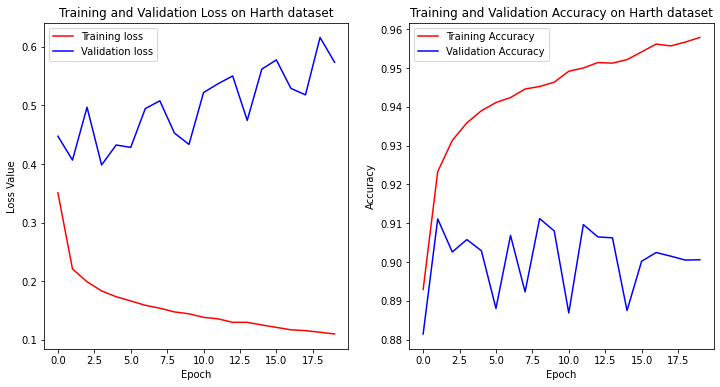

In [ ]:
history_plot('Harth')
#history_plot('mHealth')

In [ ]:
def testing_model(dataset,X_train,X_test,y_train,y_test,label_map):

  model = keras.models.load_model('/content/drive/MyDrive/best_models/' + dataset + '_best.h5')

  train_loss, train_acc = model.evaluate(X_train,y_train)
  test_loss, test_acc = model.evaluate(X_test,y_test)

  print("Train accuracy", round(train_acc*100, 2),'%')
  print("Train loss", train_loss)
  print("Test accuracy", round(test_acc*100, 2),'%')
  print("Test loss", test_loss)

  pred = model.predict(X_test)
  pred = np.argmax(pred, axis = 1)
  pred = pred.reshape(-1,1)

  from sklearn.metrics import confusion_matrix, classification_report
 
  print(classification_report(y_test,pred))
  print('*'*50)
  print(confusion_matrix(y_test,pred))

  print('Precision: %.3f' % skm.precision_score(y_test, pred, average='weighted'))
  print('Recall: %.3f' % skm.recall_score(y_test, pred, average='weighted'))
  print('F1 Score: %.3f' % skm.f1_score(y_test, pred, average='weighted'))
  
  #####plotting confusion matri#####################
  conf_matrix = confusion_matrix(y_test,pred)
  N=len(label_map)

  cf=np.empty((N,N))
  for i in range(N):
    cf[i]=(conf_matrix[i]/np.sum(conf_matrix[i]))

  group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()]
  labels = [f"{v1}" for v1 in group_percentages]
  labels = np.asarray(labels).reshape(N,N)

  fig = plt.figure(figsize=(16,12))
  ax=fig.add_subplot(111)
  sns.heatmap(conf_matrix, xticklabels=label_map.values(), yticklabels=label_map.values(), annot=labels,fmt="",cmap='RdYlBu_r',ax=ax)
  ax.set_xlabel("Predicted Labels\n\n Overall_accuracy=""{0:.2%}".format(skm.accuracy_score(y_test,pred)))
  ax.set_ylabel("True Labels")
  ax.set_title("Confusion Matrix")


404/404 [==============================] - 7s 17ms/step - loss: 0.4529 - sparse_categorical_accuracy: 0.9112
Train accuracy 94.53 %
Train loss 0.1439698338508606
Test accuracy 91.12 %
Test loss 0.45285478234291077


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

              precision    recall  f1-score   support

           1       0.77      0.85      0.81      1343
           2       0.41      0.46      0.44        26
           3       0.74      0.15      0.25       481
           4       0.00      0.00      0.00       171
           5       0.34      0.46      0.39       152
           6       0.77      0.97      0.86      1675
           7       0.99      1.00      0.99      8147
           8       0.99      0.98      0.99       535
          13       0.97      0.68      0.80       297
          14       1.00      0.03      0.07        59
         130       0.00      0.00      0.00        26
         140       0.00      0.00      0.00         3

    accuracy                           0.91     12915
   macro avg       0.58      0.47      0.47     12915
weighted avg       0.90      0.91      0.89     12915

**************************************************
[[1145    2   11    1   21  142   20    1    0    0    0    0]
 [   5   12    0   

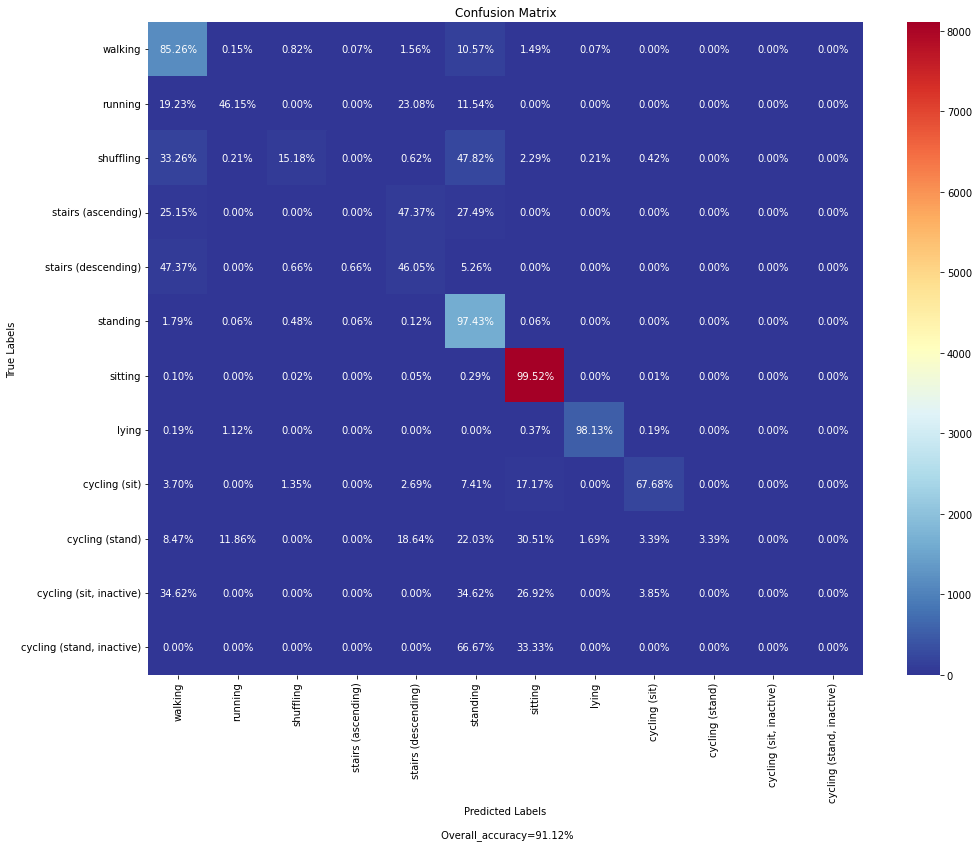

In [ ]:
testing_model('Harth',X_train_harth,X_test_harth,y_train_harth,y_test_harth,label_map_harth)

In [ ]:
def activity_wise_metrcis(n_classes,dataset,X_test,y_test,label_map):
  metrics=np.empty((0,n_classes+1))
  
  model = keras.models.load_model('/content/drive/MyDrive/best_models/' + dataset + '_best.h5')
  predy = model.predict(X_test)
  predy = np.argmax(predy, axis = 1)
  predy = predy.reshape(-1,1)

  precision=skm.precision_score(y_test, predy, average=None)
  precision_avg=skm.precision_score(y_test, predy,average='weighted')
  precision=np.hstack([precision,precision_avg])
  metrics=np.vstack([metrics,precision])

  recall=skm.recall_score(y_test, predy, average=None)
  recall_avg=skm.recall_score(y_test, predy, average='weighted')
  recall=np.hstack([recall,recall_avg])
  metrics=np.vstack([metrics,recall])

  f1=skm.f1_score(y_test, predy, average=None)
  f1_avg=skm.f1_score(y_test, predy,average='weighted')
  f1=np.hstack([f1,f1_avg])
  metrics=np.vstack([metrics,f1])

  matrix=skm.confusion_matrix(y_test,predy)
  acc=matrix.diagonal()/matrix.sum(axis=1)
  acc_avg=skm.accuracy_score(y_test,predy)
  acc=np.hstack([acc,acc_avg])
  metrics=np.vstack([metrics,acc])

  df_metrics=pd.DataFrame(metrics)
  col=list(label_map.values())
  col.append('avg')
  df_metrics.columns=col
  df_metrics.index=['precsion','recall','f1_score','accuracy']

  if not os.path.isdir('/content/drive/MyDrive/metrics'):
    os.mkdir('/content/drive/MyDrive/metrics')
  df_metrics.to_csv('/content/drive/MyDrive/metrics/Activitywise_metrics_for_'+dataset+'.csv')



In [ ]:
activity_wise_metrcis(12,'Harth',X_test_harth,y_test_harth,label_map_harth)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
